In [1]:
# Import libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from pathlib import Path
import imageio.v3 as iio
import xarray as xr
from torchvision import transforms
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import imageio.v2 as imageio
torch.set_printoptions(edgeitems=2)
from mpl_toolkits.axes_grid1 import AxesGrid
import os
import seaborn as sns
import copernicusmarine as cm

#  Custom modules
from cnn_pack import customdata
from cnn_pack import TensorSizeCheck
from cnn_pack import Graphtools
from cnn_pack import models
from cnn_pack import training

# Choose your device cuda or mps (for mac)
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('mps'))
print(f"Training on device {device}.")

Training on device mps.


## Dataset import

In [2]:
# North Sea dataset

bioid = 'cmems_mod_glo_bgc_my_0.25deg_P1M-m'
XR =  cm.open_dataset(
    dataset_id =bioid,
    start_datetime= "1993-01-01",
    end_datetime = "2022-12-01",
    minimum_latitude=50,
    maximum_latitude=72,
    minimum_longitude=-24,
    maximum_longitude=5,
    variables=['fe','o2', 'no3', 'ph', 'si', 'chl']
)

# If the datasets above take too much time to load this is google drive link for North Sea dataset
# this should download faster and work

# import gdown
# url = 'https://drive.google.com/file/d/1X8cOmlCrwUr4qZvoGvU8C0Z6ofhjecjk/view?usp=share_link'
# output = 'pisces.nc'
# gdown.download(url, output, quiet=False, fuzzy=True)
# XR = xr.load_dataset('pisces.nc')


In [3]:
# Loading dataset 

XR = XR.mean(dim = 'depth') # Choose this one for data that is averaged over depth
# XR = XR.sel(depth = XR.depth.min()).drop_vars('depth') # Choose this one for the surface data

## Tensor prep

In [4]:
all_var = ['chl','fe','no3','o2','si','ph'] # all variables i.e. features+target
data_var = ['fe','no3','o2','si','ph'] # all features 

In [5]:
# This checks the size of each variable, find number of NaNs and their indices.
# Then takes NaNS out and finds a suitable shape for the matrix without NaNs.
# PS: if you use copernicus service and download dataset this might take longer as gotta first download the dataset.

reduced_tensors = TensorSizeCheck.reduced_ten(XR, all_var)
reduced_tensors.fit()
reduced_tensors.find_divisor()

new_shape = reduced_tensors.redten_shape
new_size = reduced_tensors.redten_size

There are 1253 NaNs for each feature at every month and their places are the same.
Your original tensor of size (93, 117) = 10881 is reduced to 9628 = (83, 116).


In [6]:
# Tranform the data to reduced tensors using the dimensions we have above
X = reduced_tensors.nona(data_var,new_shape).permute(1,0,2,3).contiguous()
y = reduced_tensors.nona(['chl'],new_shape).squeeze(-4).contiguous()

# Determine number of samples for train and test split
test_index = int(X.shape[0]*0.2)
train_index = int(X.shape[0]-X.shape[0]*0.2)

y_train = y[:-test_index].to(device = device)
X_train = X[:-test_index].to(device = device)

X_val = X[train_index:].to(device = device)
y_val = y[train_index:].to(device = device)

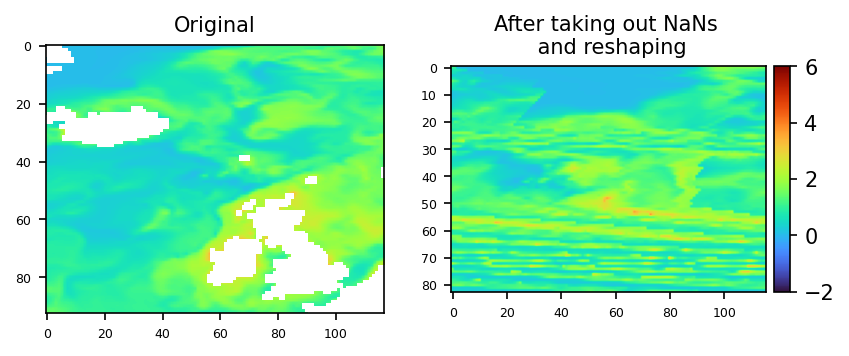

In [7]:
# Below is an example what happens to data after transformation
fig, (ax, ax2) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 1]})
im  = ax.imshow( np.flipud(XR['chl'][15]),cmap ='turbo')
im2 = ax2.imshow( np.flipud(y[3].to(device='cpu')),cmap ='turbo')
ax.set_title('Original',fontsize = 10)
ax2.set_title('After taking out NaNs \n and reshaping',fontsize = 10)
divider = make_axes_locatable(ax2)
im.set_clim(-2, 6)
im2.set_clim(-2, 6)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax)
ax.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(150)
plt.show()

In [8]:
# Computing mean and std of train set for normalization

mean_train = X_train.permute(1,2,3,0).contiguous().view(5,-1).mean(dim = 1)
std_train = X_train.permute(1,2,3,0).contiguous().view(5,-1).std(dim = 1)

In [9]:
batch = 12 # number of batches in train, val loader
n_epochs = 200
learning_rate = 1e-2

# Defining custom datasets for normalization and loaders
train_dataset = customdata.MyDataset(X_train, y_train, 
                                     transforms.Normalize(mean=mean_train,std=std_train))
train_norm = torch.utils.data.TensorDataset(train_dataset.transform(train_dataset.data),y_train)
train_loader = torch.utils.data.DataLoader(train_norm, batch_size=batch,
                                           shuffle=True)

val_dataset = customdata.MyDataset(X_val, y_val, 
                                     transforms.Normalize(mean=mean_train,std=std_train))
val_norm = torch.utils.data.TensorDataset(val_dataset.transform(val_dataset.data),y_val)
val_loader = torch.utils.data.DataLoader(val_norm, batch_size=batch)

all_acc_dict = collections.OrderedDict() # dictionary for storing final training and validation values for each model

## Training

In [10]:
# Loading a model and training loop

model_batch = models.NetBatchNorm(n_chans1=32, ten_size= reduced_tensors.redten_size
                            , poolten_size= reduced_tensors.poolsize).to(device = device)  
optimizer = optim.SGD(model_batch.parameters(), lr=learning_rate)  
loss_fn = nn.MSELoss()  

model_batch_list = training.training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model_batch,
    loss_fn = loss_fn,
    batchsize = batch,
    train_loader = train_loader,
    val_loader = val_loader
)

all_acc_dict[model_batch.__class__.__name__] = training.validate(model_batch, batch, train_loader, val_loader,loss_fn)

 Epoch 1| Training rmse 0.6416403750481795 | Validation rmse 0.6353449207720603 
 Epoch 10| Training rmse 0.4277228672476912 | Validation rmse 0.43322117007996563 
 Epoch 20| Training rmse 0.3604331182699206 | Validation rmse 0.36391870908918916 
 Epoch 30| Training rmse 0.3352640331200769 | Validation rmse 0.3406115223029291 
 Epoch 40| Training rmse 0.30968044053988303 | Validation rmse 0.3170697864469988 
 Epoch 50| Training rmse 0.2852516961722215 | Validation rmse 0.29327202676243586 
 Epoch 60| Training rmse 0.26537965799414764 | Validation rmse 0.2751072604888796 
 Epoch 70| Training rmse 0.25101048367713613 | Validation rmse 0.2630258546324739 
 Epoch 80| Training rmse 0.24101805954924133 | Validation rmse 0.2554320365392107 
 Epoch 90| Training rmse 0.23383495113627878 | Validation rmse 0.25001865555775504 
 Epoch 100| Training rmse 0.2286244022098427 | Validation rmse 0.2465484243725795 
 Epoch 110| Training rmse 0.22466768962467257 | Validation rmse 0.24369785594728816 
 Epo

In [11]:
# Loading a model and training loop

model_dropout = models.NetDropout(n_chans1=32, ten_size= reduced_tensors.redten_size
                            , poolten_size=reduced_tensors.poolsize).to(device = device)  
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate)  
loss_fn = nn.MSELoss()  

model_dropout_list = training.training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model_dropout,
    loss_fn = loss_fn,
    batchsize = batch,
    train_loader = train_loader,
    val_loader = val_loader)

all_acc_dict[model_dropout.__class__.__name__] = training.validate(model_dropout, batch, train_loader, val_loader,loss_fn)

 Epoch 1| Training rmse 0.6357146568216572 | Validation rmse 0.6354698031257061 
 Epoch 10| Training rmse 0.548545756279205 | Validation rmse 0.5573616711746018 
 Epoch 20| Training rmse 0.4046591538458299 | Validation rmse 0.4118835288376975 
 Epoch 30| Training rmse 0.371294955869535 | Validation rmse 0.3738182009419725 
 Epoch 40| Training rmse 0.3613600128296472 | Validation rmse 0.363572653248699 
 Epoch 50| Training rmse 0.3521488664151593 | Validation rmse 0.35506924861868405 
 Epoch 60| Training rmse 0.3414328384921177 | Validation rmse 0.3455501692164463 
 Epoch 70| Training rmse 0.3292015868865335 | Validation rmse 0.3348921936048967 
 Epoch 80| Training rmse 0.3157798191356974 | Validation rmse 0.3230205959561946 
 Epoch 90| Training rmse 0.30177894819696954 | Validation rmse 0.3102130655286846 
 Epoch 100| Training rmse 0.2879170752641237 | Validation rmse 0.29646101747764514 
 Epoch 110| Training rmse 0.2749747671576711 | Validation rmse 0.283738787267773 
 Epoch 120| Trai

In [12]:
# Loading a model and training loop

model_resnet = models.NetResDeep(n_chans1=32, ten_size= reduced_tensors.redten_size
                            , poolten_size=reduced_tensors.poolsize).to(device = device)  
optimizer = optim.SGD(model_resnet.parameters(), lr=learning_rate)  
loss_fn = nn.MSELoss()  

model_resnet_list = training.training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model_resnet,
    loss_fn = loss_fn,
    batchsize = batch,
    train_loader = train_loader,
    val_loader = val_loader
)
all_acc_dict[model_resnet.__class__.__name__] = training.validate(model_resnet, batch, train_loader, val_loader,loss_fn)

 Epoch 1| Training rmse 0.662118746635857 | Validation rmse 0.5770913239441136 
 Epoch 10| Training rmse 0.33714431735942757 | Validation rmse 0.3570632073021308 
 Epoch 20| Training rmse 0.2799792725908168 | Validation rmse 0.3022434047564979 
 Epoch 30| Training rmse 0.24664349309312766 | Validation rmse 0.27509351354153544 
 Epoch 40| Training rmse 0.230164001108369 | Validation rmse 0.2627076012574467 
 Epoch 50| Training rmse 0.22105702226013288 | Validation rmse 0.2536684928240148 
 Epoch 60| Training rmse 0.21590583352514256 | Validation rmse 0.2488836818796076 
 Epoch 70| Training rmse 0.21161235186293575 | Validation rmse 0.2446866592284788 
 Epoch 80| Training rmse 0.2080601822531435 | Validation rmse 0.24175179420237353 
 Epoch 90| Training rmse 0.2055283735525521 | Validation rmse 0.2411851573145603 
 Epoch 100| Training rmse 0.20283054404217812 | Validation rmse 0.2369252626539609 
 Epoch 110| Training rmse 0.20082094391389213 | Validation rmse 0.2368128969646928 
 Epoch 1

## Results

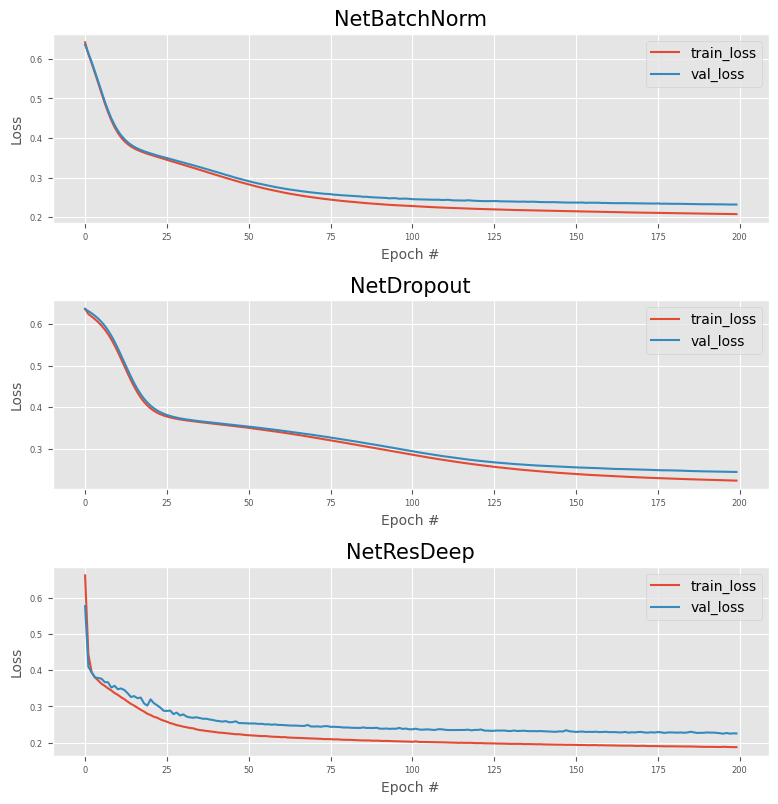

In [20]:
# Loss plots of the models

mod_loss_list = {model_batch.__class__.__name__ :model_batch_list, model_dropout.__class__.__name__ : model_dropout_list
                 , model_resnet.__class__.__name__ : model_resnet_list}

n_ep = np.arange(0, len(model_batch_list["loss"]))
(fig, axs) = plt.subplots(3, 1,figsize = (8,8))

for i, key in enumerate(mod_loss_list):
  plt.style.use("ggplot")
  fig.tight_layout()
  axs[i].plot(n_ep, mod_loss_list[key]["loss"], label="train_loss")
  axs[i].plot(n_ep, mod_loss_list[key]["val_loss"], label="val_loss")
  axs[i].set_title("{}".format(key),fontsize = 15)
  axs[i].set_xlabel("Epoch #",fontsize = 10)
  axs[i].set_ylabel("Loss",fontsize = 10)
  axs[i].tick_params(axis='both', which='major', labelsize=6)
  axs[i].legend()
  plt.gcf().set_dpi(100)

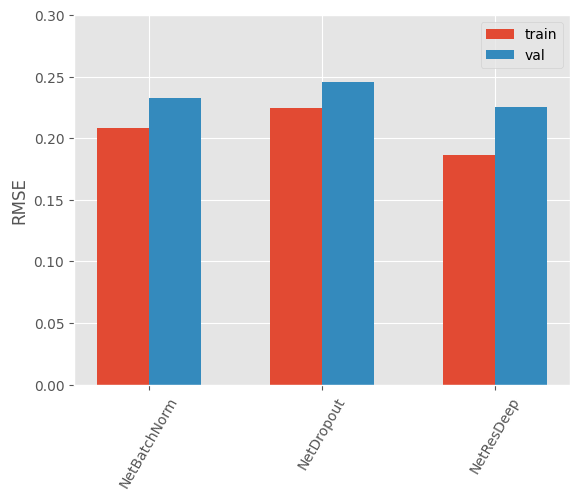

In [14]:
# Comparing different models

trn_rmse = [v['train'] for k, v in all_acc_dict.items()]
val_rmse = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_rmse)), trn_rmse, width=width, label='train')
plt.bar(np.arange(len(val_rmse))+ width, val_rmse, width=width, label='val')
plt.xticks(np.arange(len(val_rmse))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.ylim(0,0.3)
plt.savefig('rmse_comparison.png', bbox_inches='tight')
plt.show()


In [16]:
# This part will create images, gifs folders then creates and stitch images 
# of prediction and validation, finally stacks those in a gif.

mod_resnet = Graphtools.grapher(model_resnet, val_dataset.transform(val_dataset.data), y_val, reduced_tensors.redten_shape)
mod_resnet_pred =mod_resnet.pred_lister() #run this once
mod_resnet.plotter(reduced_tensors.revert)

mod_batch = Graphtools.grapher(model_batch, val_dataset.transform(val_dataset.data), y_val, reduced_tensors.redten_shape)
mod_batch_pred = mod_batch.pred_lister() #run this once
mod_batch.plotter(reduced_tensors.revert)

mod_dropout = Graphtools.grapher(model_dropout, val_dataset.transform(val_dataset.data), y_val, reduced_tensors.redten_shape)
mod_dropout_pred = mod_dropout.pred_lister() #run this once
mod_dropout.plotter(reduced_tensors.revert)

## Plot for distribution of RMSEs

In [17]:
#average rmse by hand for a model to check the distribution of 
residuals = []
for i in np.arange(np.array(mod_resnet_pred).shape[0]):
    residuals.append(((y_val.to(device = 'cpu').numpy()[i]-np.array(mod_resnet_pred)[i])**2).flatten())

print(f'rmse {np.sqrt(np.array(residuals).mean(axis= 0).mean())}')

re_std = np.array(residuals).mean(axis=0).std()
re_mean = np.sqrt(np.array(residuals).mean(axis=0)).mean()
(re_std, re_mean)

rmse 0.22538672387599945


(0.041937396, 0.21154323)

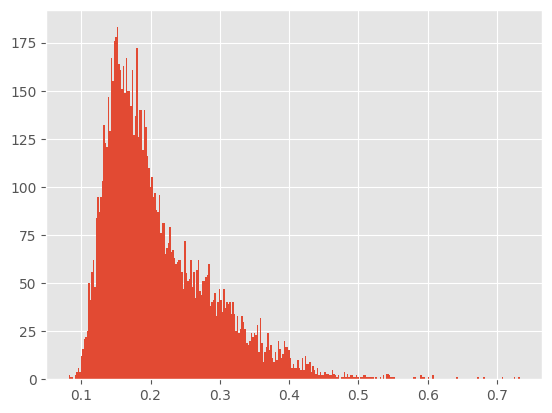

In [18]:
# distribution of rmses
plt.hist(np.sqrt(np.array(residuals).mean(axis=0)),bins = 300)
plt.show()

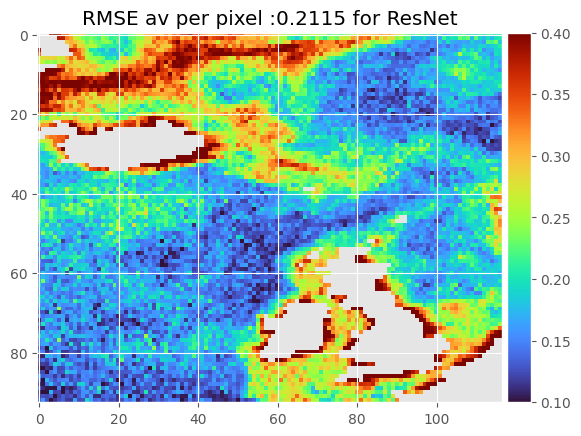

In [19]:
ax = plt.subplot()
im = ax.imshow(np.flipud(reduced_tensors.revert(np.sqrt(np.array(residuals).mean(axis=0)))),cmap='turbo')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im.set_clim(vmin= 0.1 ,vmax= 0.4)
ax.set_title('RMSE av per pixel :{:.4f} for ResNet'.format(np.sqrt(np.array(residuals).mean(axis= 0)).mean()))
plt.colorbar(im, cax=cax)
plt.show()